<a href="https://colab.research.google.com/github/adunuthulan/LanguageLevel/blob/master/LanguageLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing The Reading Level of Text with Machine Learning**
By Nirav Adunuthula
Started Oct 11, 2019

I have recently wondered if the saying, "All news articles are written at a fourth grade reading level", was true. This is a project to try and answer that question.

##Why Predict Reading Level?
For beginnners, learning a language is difficult. You need to speak, hear, and read the language to gain full literacy. For people unable to join a class, the internet is a great resource for free material; however, there isn't always a clear guide for what books are at a person's level that will help them improve their literacy. The issue I've run into is as such: **how would one categorize writing into a reading level?**

Here are some features off the top of my head that logically would correspond to reading level:
* The complexity of the words used/the maturity level
* The average word/sentence length
* The use of complex punctuation/grammar (colons, dashes, etc.)

The company Lexile has a tool to determine the reading level of a text, and they use an algorithm based upon similar features. The info for this analyzer can be found [here](https://lexile.com/educators/tools-to-support-reading-at-school/tools-to-determine-a-books-complexity/).

There might be other features that we are not considering or that are not clear to us. For that, we can use Machine Learning. 

## The Data

But in order to use ML, we need Data. Books used pedalogically in schools have somewhat well defined levels of reading with the grade the books are taught at, 
so I shall use them as my training data. Words by themselves are difficult to categorize into reading levels ('the' is probably in every work of literature), so **I shall feed in chapters of books alongside the grade they are taught at as my data.**

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import itertools
import random

print("Tensorflow version: ", tf.__version__)
print("Hub version: ", hub.__version__)

Tensorflow version:  2.3.0
Hub version:  0.8.0


In [3]:
nltk.download("book")

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2000.zip.
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2002.zip.
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/dependency_treebank.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    

True

In [4]:
#mount drive when using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#import readingdata in a csv file and put it in a pandas data frame

path = "/content/drive/My Drive/Colab Notebooks/LanguageLevelData/CSV/readingdata.csv"
rd = pd.read_csv(path)
print(rd)

                                                Text   ReadingLevel
0  Pedro wants to ride his skateboard. Pedro has ...              1
1  People eat shrimp. Shrimp comes from the ocean...              1
2  Look at all of these big buildings! This is a ...              2
3  The environment is all around you. Rocks, soil...              2
4  Cactus pygmy-owls are little birds. They are a...              3


### Pre-processing the Data
The data is in the form (String text, int grade_level). We will obtain some features from the data like number of sentences in each text and the number of times each word is repeated. We will ignore any punctuation and possibly discount some common words like 'and' or 'a' in the feature list we use to train a classifier.

In [95]:
#Preprocess the text data which is in the form (String text, int grade_level)

target_labels = rd.loc[:,' ReadingLevel'].values.tolist() #book target labels
print("Target Labels: ", target_labels)

sentences = [] #sentences for each book
labeled_sentences = [] #each sentence and the reading level associated with it

for row in rd.itertuples():
  sentences.append(nltk.sent_tokenize(row[1].lower()))
  labeled_sentences.append((sent, row[2]) for sent in sentences[-1])

#the number of sentences in each text
num_sents = [len(sent) for sent in sentences] 

#tokenize text without punctuation
tokenized_text = [] 
for row in rd.itertuples():
  tokenized_text.append([w for w in nltk.word_tokenize(row[1].lower()) if w.isalnum()])
print(tokenized_text[0])

num_words = [len(words) for words in tokenized_text] #the number of words in a book

#get the average words per sentence in each text
avg_book_sentence_length = [w/s for w, s in zip(num_words, num_sents)]
print ("Book 1 has %d words on average." % avg_sentence_length[0])
print("AAA:", len(avg_book_sentence_length))

#find the frequency of words in sentences
word_freq = [nltk.FreqDist(t_sent) for t_sent in tokenized_text]
print ("Found %d unique word tokens in book 1" % len(word_freq[0].items()))

#get aggregate data depending on level
num_books = dict()
avg_words = dict()
avg_sents = dict()
for i, label in enumerate(target_labels):
  num_books.update({label: num_books.get(label, 0) + 1})
  avg_words.update({label: avg_words.get(label, 0) + num_words[i]})
  avg_sents.update({label: avg_sents.get(label, 0) + num_sents[i]})

for label in num_books.keys():
  avg_words[label]/=num_books[label]
  avg_sents[label]/=num_books[label]

print(avg_sents)

feature_list = pd.DataFrame()
feature_list["bookID"] = [x for x in range(len(rd))]
feature_list["num_words"] = num_words
feature_list["num_sents"] = num_sents
feature_list["sent_length"] = avg_book_sentence_length

print(feature_list)

Target Labels:  [1, 1, 2, 2, 3]
['pedro', 'wants', 'to', 'ride', 'his', 'skateboard', 'pedro', 'has', 'pads', 'for', 'his', 'knees', 'he', 'also', 'has', 'pads', 'for', 'his', 'elbows', 'he', 'has', 'pads', 'for', 'his', 'hands', 'he', 'puts', 'on', 'his', 'helmet', 'pedro', 'puts', 'on', 'his', 'safety', 'shoes', 'he', 'has', 'his', 'skateboard', 'let', 'have', 'fun']
Book 1 has 5 words on average.
AAA: 5
Found 22 unique word tokens in book 1
{1: 10.5, 2: 35.5, 3: 121.0}
   bookID  num_words  num_sents  sent_length
0       0         43          8     5.375000
1       1         59         13     4.538462
2       2        246         28     8.785714
3       3        348         43     8.093023
4       4       1000        121     8.264463


Let's plot some of the dataset's metrics to get an understanding of our data.

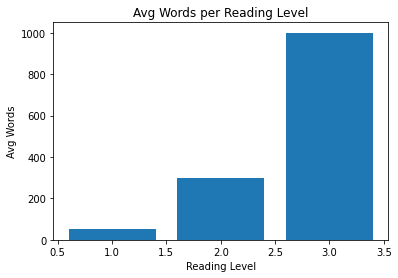

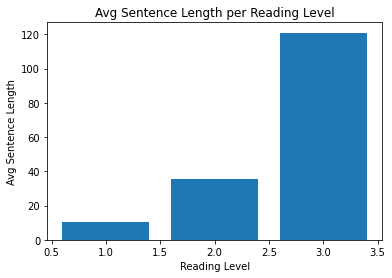

In [58]:
def plot_avg_words():
    x, y = zip(*sorted(avg_words.items()))
    
    plt.bar(x, y)
    plt.xlabel('Reading Level')
    plt.ylabel('Avg Words')
    plt.title('Avg Words per Reading Level')
    plt.show()

def plot_avg_sents():
    x, y = zip(*sorted(avg_sents.items()))
    
    plt.bar(x, y)
    plt.xlabel('Reading Level')
    plt.ylabel('Avg Sentence Length')
    plt.title('Avg Sentence Length per Reading Level')
    plt.show()

plot_avg_words()
plot_avg_sents()

In [7]:
def shuff(batch_size):
  sent_shuff = sentences[0:batch_size]
  return random.shuffle(sent_shuff)
def batch(batch_size):
  return sentences[0:batch_size]

###Using the Tensorflow Dataset Pipeline
Instead of Pre-Processing the data into tokenized sentences for our own ML analysis, we can also transform the csv into a TF Dataset so it can be easily piped into TF.

In [98]:
target = rd.pop(' ReadingLevel')
embedded_dataset = tf.data.Dataset.from_tensor_slices((rd.values[:, 0], target.values))
processed_dataset = tf.data.Dataset.from_tensor_slices((feature_list.values[:, 1:], target.values))

for feat, targ in embedded_dataset.take(3):
  print ('Features: {}, Target: {}'.format(feat, targ))

for feat, targ in processed_dataset.take(3):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b"Pedro wants to ride his skateboard. Pedro has pads for his knees. he also has pads for his elbows. He has pads for his hands. He puts on his helmet. Pedro puts on his safety shoes. He has his skateboard. Let's have fun!", Target: 1
Features: b'People eat shrimp. Shrimp comes from the ocean. People eat clams. Clams come from the ocean. People eat lobsters. Lobsters come from the ocean. People eat small fish. Small fish come from the ocean. People eat big fish. Big fish come from the ocean. People eat mussels. Mussels come from the ocean. People eat many foods from the ocean.', Target: 1
Features: b'Look at all of these big buildings! This is a city. A city is an urban community. An urban community is a place where many people live. Do you know what these big buildings are? They are apartment buildings. Many people in urban communities live in apartments. People in all communities work. Some people in cities work in factories. Factories make things like cars, tools, and toys.

In [100]:
#the percent of the data that goes into the training set VS validation set
percentTV = .8

#split up the data, using a percentage for the training set and all the data for testing
num_take = tf.cast((len(rd)*percentTV), tf.int64)
train_data = (embedded_dataset.take(num_take), processed_dataset.take(num_take))
validation_data = (embedded_dataset.skip(num_take).take(len(rd)-num_take), 
                   processed_dataset.skip(num_take).take(len(rd)-num_take))
test_data = (embedded_dataset, processed_dataset)


PS : How to flatten a matrix into a single array

`flattened = [val for sublist in sentences for val in sublist]`

## Setting up a Model with Tensorflow

I will be using the Keras Functional model that allows for a more complex model architecture. 

My first input will be the words themselves, and that section of the model will predict the class (grade level) based upon features it finds. The words will be encoded by a THub word encoding layer, and then passed through a few dense layers. 

The second section of the model will take the word/sentence length, complexity/maturity, etc. as Inputs (features that I find).

#### Using Our Pre-Processed Text

In [101]:
#https://keras.io/guides/functional_api/
processed_input = keras.Input(shape=(3, ), name = "processed_input")

#### Using TensorFlow-Hub
Rather than training on features, we can also have the computer itself look at the text and reading levels and try and come up with its own way of classifying the text. We will use Tensorflow-Hub to have another means of processing the text into a shape keras can use.


In [102]:
#Set up the layers of the model using the Sequential API.

embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

#hub_layer()

embedded_model = tf.keras.Sequential()

embedded_model.add(hub_layer)
embedded_model.add(tf.keras.layers.Dense(16, activation='relu'))
embedded_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

embedded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_18 (KerasLayer)  (None, 20)                400020    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [103]:
#following the tensorflow.org tutorial on ML on text
embedded_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [104]:
mergedOut = tf.keras.layers.Concatenate()([embedded_model.output, processed_input])
mergedOut = tf.keras.layers.Dense(1, activation='sigmoid') (mergedOut)

In [115]:
model = tf.keras.Model([embedded_model.input, processed_input], mergedOut)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
keras_layer_18_input (InputLaye [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_18 (KerasLayer)     (None, 20)           400020      keras_layer_18_input[0][0]       
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 16)           336         keras_layer_18[0][0]             
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1)            17          dense_5[0][0]                    
_______________________________________________________________________________________

In [108]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
for a, b in train_data.batch(num_take).take(5):
  print("Feature shape: ", a.shape)
  print("Target shape: ", b.shape)

Feature shape:  (4,)
Target shape:  (4,)


In [ ]:
history = model.fit(train_data[0].shuffle(num_take).batch(2),
                    epochs=4,
                    validation_data=validation_data[0].batch(len(rd)-num_take),
                    verbose=1)

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
results = model.evaluate(test_data.batch(5), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

1/1 - 0s - loss: -6.8731e-01 - accuracy: 0.4000
loss: -0.687
accuracy: 0.400


In [40]:
print(model.predict(["A banana was walking down the road when he tripped into the water."]))


[[0.5794918]]
